In [1]:
import os
import glob
import json
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.ops import box_iou
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
class JAADDataset(Dataset):
    def __init__(self, ann_file, all_images_dir, img_size=224,
                 split='train', val_frac=0.2, test_frac=0.1):
        data = json.load(open(ann_file))
        self.anns_by_img = {}
        self.id_by_img   = {}
        for ann in data['annotations']:
            p = ann['file_path']
            self.anns_by_img.setdefault(p, []).append(ann)
            self.id_by_img[p] = ann['image_id']

        next_id = max(self.id_by_img.values(), default=0) + 1
        for p in glob.glob(f"{all_images_dir}/**/*.jpg", recursive=True):
            if p not in self.anns_by_img:
                self.anns_by_img[p] = []
                self.id_by_img[p]   = next_id
                next_id += 1

        all_paths = sorted(self.anns_by_img)
        n = len(all_paths)
        n_val  = int(val_frac * n)
        n_test = int(test_frac * n)
        n_train = n - n_val - n_test
        splits = (['train'] * n_train +
                  ['val']   * n_val +
                  ['test']  * n_test)
        self.split_paths = [p for s,p in zip(splits, all_paths) if s==split]

        self.img_size = img_size
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.split_paths)

    def __getitem__(self, idx):
        path = self.split_paths[idx]
        img  = Image.open(path).convert('RGB')
        w0, h0 = img.size
        timg = self.transform(img)

        boxes, labels = [], []
        for ann in self.anns_by_img[path]:
            if 'bbox' not in ann or ann['bbox'] is None:
                continue
            else:
                x, y, w, h = ann['bbox']
                
            x1, y1 = x / w0, y / h0
            x2, y2 = (x + w) / w0, (y + h) / h0
            boxes.append([x1, y1, x2, y2])
            labels.append(1)

        target = {
            'boxes':    torch.tensor(boxes, dtype=torch.float32),
            'labels':   torch.tensor(labels, dtype=torch.int64),
            'image_id': torch.tensor(self.id_by_img[path], dtype=torch.int64),
        }
        return timg, target


In [3]:
def collate_fn(batch):
    imgs, tgts = zip(*batch)
    return torch.stack(imgs), tgts

In [4]:
class ViTDetection(nn.Module):
    def __init__(self, image_size=224, patch_size=16, in_channels=3,
                 embed_dim=256, depth=6, num_heads=8, num_queries=100,
                 num_classes=2):
        super().__init__()
        self.patch_embed = nn.Conv2d(in_channels, embed_dim,
                                     kernel_size=patch_size,
                                     stride=patch_size)
        num_patches = (image_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, embed_dim))

        enc_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=depth)

        self.query_embed = nn.Embedding(num_queries, embed_dim)
        dec_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.decoder = nn.TransformerDecoder(dec_layer, num_layers=depth)

        self.class_head = nn.Linear(embed_dim, num_classes)
        self.bbox_head  = nn.Linear(embed_dim, 4)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed
        memory = self.encoder(x)

        queries = self.query_embed.weight.unsqueeze(0).repeat(B, 1, 1)
        hs = self.decoder(queries, memory)

        logits = self.class_head(hs)
        bboxes = self.bbox_head(hs).sigmoid()
        return {'pred_logits': logits, 'pred_boxes': bboxes}

In [5]:
from torchvision.ops import box_iou

def cxywh_to_xyxy(boxes):
    cx, cy, w, h = boxes.unbind(-1)
    x1 = cx - 0.5*w; y1 = cy - 0.5*h
    x2 = cx + 0.5*w; y2 = cy + 0.5*h
    return torch.stack([x1, y1, x2, y2], dim=-1)

def detection_loss(outputs, targets):
    logits = outputs['pred_logits']
    preds  = outputs['pred_boxes']
    B, Q, C = logits.shape

    labels = []
    for t in targets:
        K = t['boxes'].size(0)
        lbl = torch.cat([
            torch.ones(K, dtype=torch.long),
            torch.zeros(Q-K, dtype=torch.long)
        ])
        labels.append(lbl)
    labels = torch.stack(labels).view(-1).to(logits.device)

    cls_loss = F.cross_entropy(logits.view(-1, C), labels)

    l1_loss = 0
    for b in range(B):
        gt = targets[b]['boxes'].to(preds.device)
        K  = gt.size(0)
        if K>0:
            pred_xyxy = cxywh_to_xyxy(preds[b])
            l1_loss += F.l1_loss(pred_xyxy[:K], gt)
    l1_loss = l1_loss / B

    return cls_loss + l1_loss

def evaluate_map(model, loader, device):
    model.eval()
    all_ious = []
    with torch.no_grad():
        for imgs, targets in tqdm(loader, desc="Evaluating", leave=False):
            imgs = torch.stack(imgs).to(device)
            out = model(imgs)
            pred_xyxy = cxywh_to_xyxy(out['pred_boxes']).cpu()
            for pb, t in zip(pred_xyxy, targets):
                gt = t['boxes']
                if gt.numel()==0: continue
                iou_mat = box_iou(pb, gt)
                all_ious.append(iou_mat.diag().mean().item())
    return sum(all_ious)/len(all_ious) if all_ious else 0

In [6]:
def train_model(model, train_loader, val_loader, device,
                num_epochs=5, lr=1e-4):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0

        for imgs, targets in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
            imgs = torch.stack(imgs).to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(imgs)
            loss = detection_loss(outputs, targets)

            # **Use the optimizer instance here:**
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        val_iou = evaluate_map(model, val_loader, device)
        print(f"Epoch {epoch}: Train Loss={avg_train_loss:.4f}")


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_ds = JAADDataset("annotations_with_paths.json", "images", split="train")
val_ds   = JAADDataset("annotations_with_paths.json", "images", split="val")
test_ds  = JAADDataset("annotations_with_paths.json", "images", split="test")

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,
                          collate_fn=lambda x: tuple(zip(*x)))
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False,
                          collate_fn=lambda x: tuple(zip(*x)))
test_loader  = DataLoader(test_ds,  batch_size=8, shuffle=False,
                          collate_fn=lambda x: tuple(zip(*x)))

model = ViTDetection()
train_model(model, train_loader, val_loader, device,
            num_epochs=10, lr=1e-4)

Epoch 1: Train Loss=0.1159


Epoch 2: Train Loss=0.1019


Epoch 3: Train Loss=0.0899


Epoch 4: Train Loss=0.0753


Epoch 5: Train Loss=0.0629


Epoch 6: Train Loss=0.0532


Epoch 7: Train Loss=0.0466


Epoch 8: Train Loss=0.0420


Epoch 9: Train Loss=0.0396


Epoch 10: Train Loss=0.0372


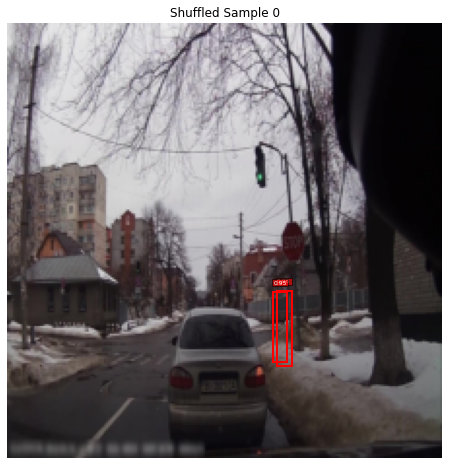

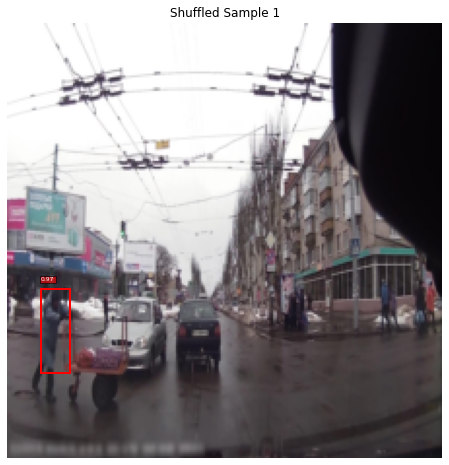

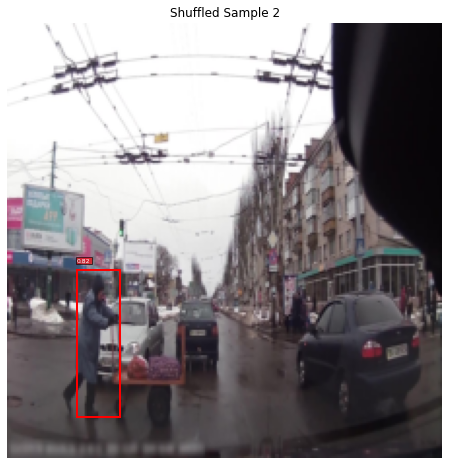

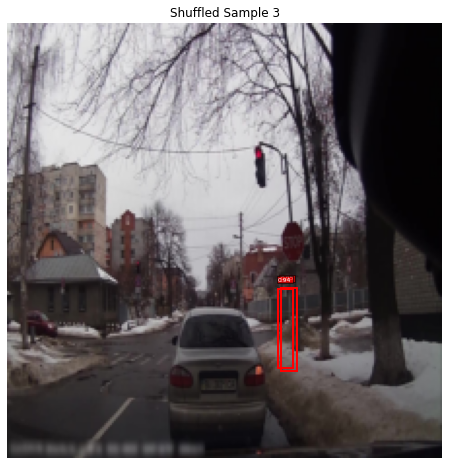

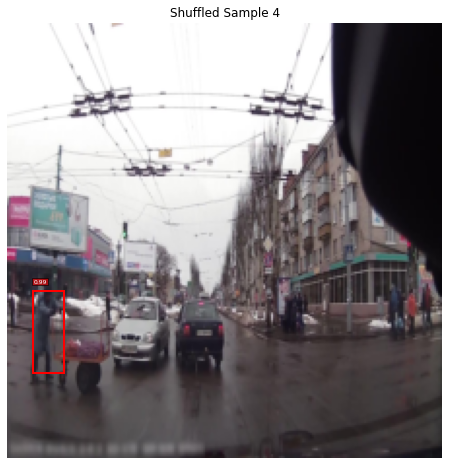

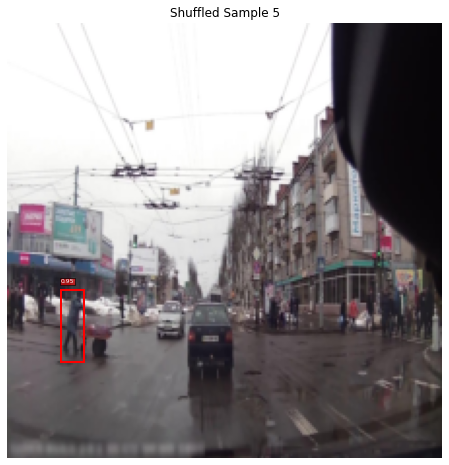

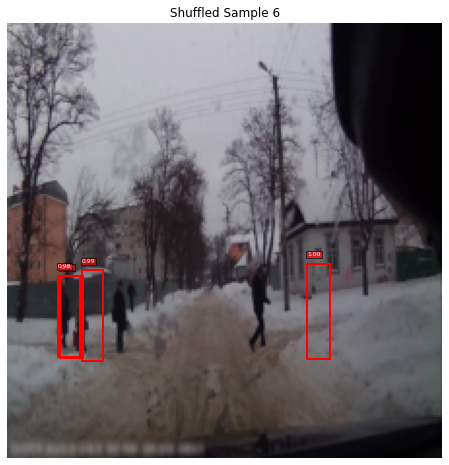

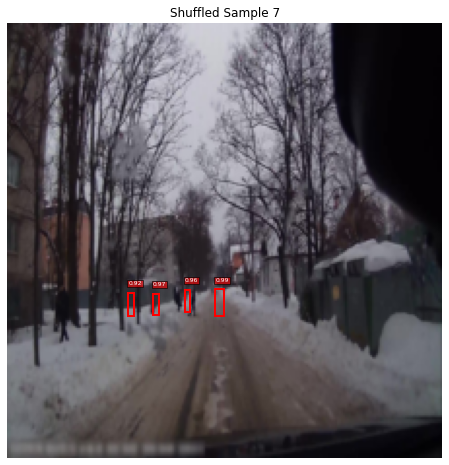

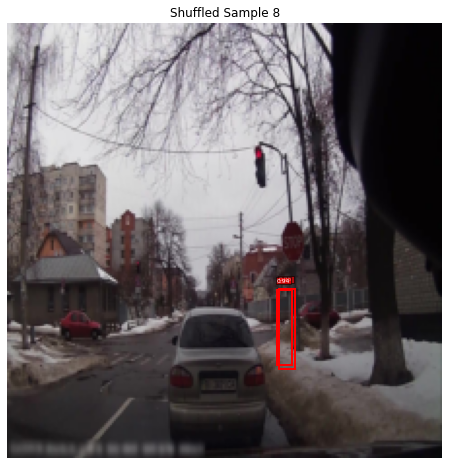

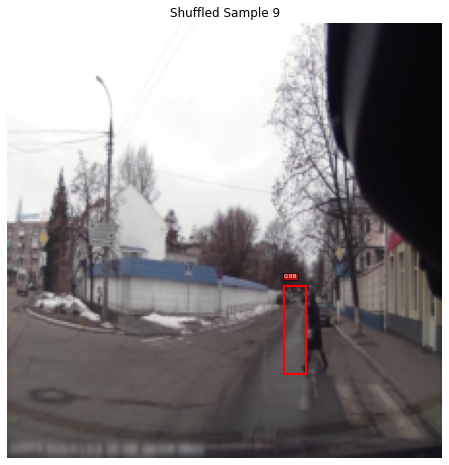

In [9]:
%matplotlib inline
import torch.nn.functional as F
from torch.utils.data import DataLoader

shuffled_loader = DataLoader(
    test_ds,
    batch_size=1,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x))
)

model.eval()
for i, (imgs, targets) in enumerate(shuffled_loader):
    if i >= 10:
        break

    img    = imgs[0]
    target = targets[0]

    with torch.no_grad():
        out        = model(img.unsqueeze(0).to(device))
        pred_boxes = cxywh_to_xyxy(out['pred_boxes'])[0].cpu()
        probs      = F.softmax(out['pred_logits'][0], dim=-1)[:,1].cpu()

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(img.permute(1, 2, 0))
    ax.axis('off')
    ax.set_title(f"Shuffled Sample {i}")

    thresh = 0.6
    keep = (probs > thresh).nonzero(as_tuple=False).squeeze(1)
    for idx in keep:
        x1, y1, x2, y2 = (pred_boxes[idx] * test_ds.img_size).tolist()
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             fill=False, edgecolor='r', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1 - 4, f"{probs[idx]:.2f}",
                color='white',
                bbox=dict(facecolor='r', alpha=0.6, pad=1),
                fontsize=6)

    plt.show()